<a href="https://colab.research.google.com/github/obaidsi/Time-domain-signal-denoising/blob/main/time_domain_signal_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Domain Signal Denoising & Feature Enhancement

## Overview
This notebook demonstrates practical time-domain signal preprocessing techniques used to improve signal quality and enhance transient activity in noisy data. The methods shown here are commonly used in DSP pipelines for sensor and biomedical-style signals.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def windowed_mean_smoother(x, k):
    """
    Windowed mean smoothing.
    For each sample t, replace x[t] with the mean of x[t-k : t+k+1].
    Edges are left unchanged to avoid boundary issues.
    """
    x = np.asarray(x, dtype=float)
    y = x.copy()
    n = len(x)

    for t in range(k, n - k):
        y[t] = np.mean(x[t - k : t + k + 1])

    return y


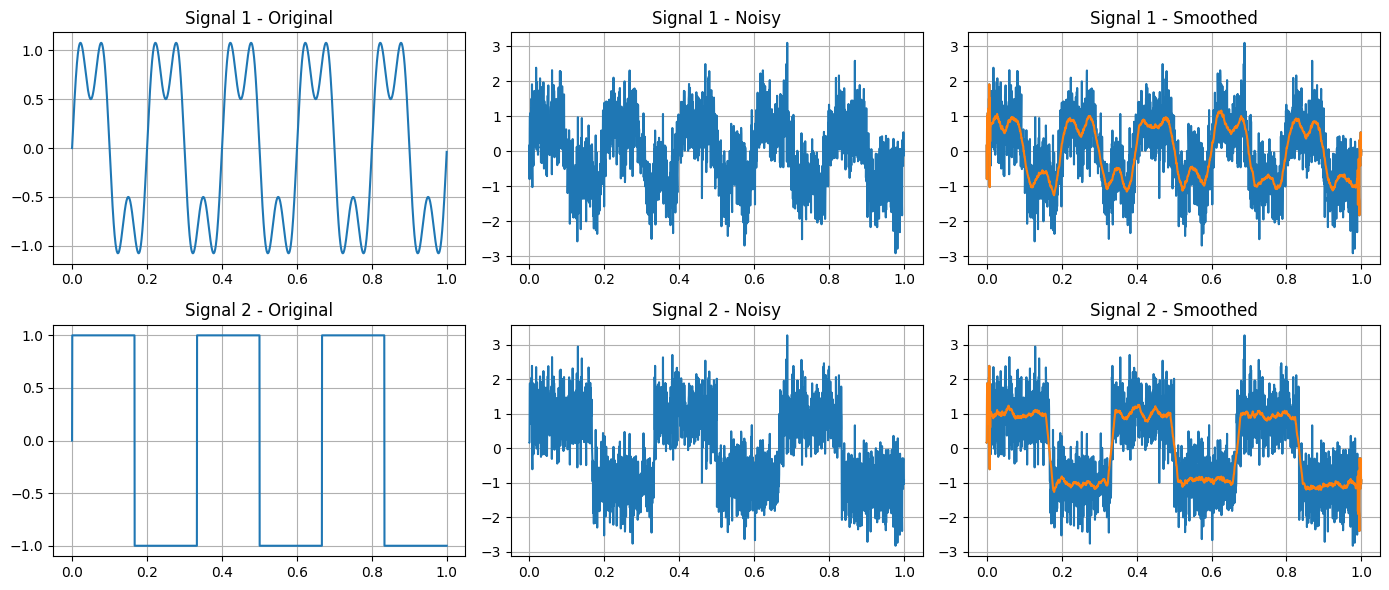

In [7]:
# Parameters
n = 2000
t = np.linspace(0, 1, n, endpoint=False)

k = 20          # smoothing half-window
noise_amp = 0.6 # try 0.2, 0.6, 1.0 later

# Two different base signals (different shapes)
x1 = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*15*t)    # smooth multi-tone
x2 = np.sign(np.sin(2*np.pi*3*t))                      # square-like

# Same noise added to both
noise = noise_amp * np.random.randn(n)
x1_noisy = x1 + noise
x2_noisy = x2 + noise

# Apply windowed mean smoothing
x1_smooth = windowed_mean_smoother(x1_noisy, k)
x2_smooth = windowed_mean_smoother(x2_noisy, k)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# ---------- FIRST SIGNAL ----------
# Original
axes[0][0].plot(t, x1)
axes[0][0].set_title("Signal 1 - Original")

# Noisy
axes[0][1].plot(t, x1_noisy)
axes[0][1].set_title("Signal 1 - Noisy")

# Noisy + Smoothed
axes[0][2].plot(t, x1_noisy)
axes[0][2].plot(t, x1_smooth)
axes[0][2].set_title("Signal 1 - Smoothed")


# ---------- SECOND SIGNAL ----------
# Original
axes[1][0].plot(t, x2)
axes[1][0].set_title("Signal 2 - Original")

# Noisy
axes[1][1].plot(t, x2_noisy)
axes[1][1].set_title("Signal 2 - Noisy")

# Noisy + Smoothed
axes[1][2].plot(t, x2_noisy)
axes[1][2].plot(t, x2_smooth)
axes[1][2].set_title("Signal 2 - Smoothed")


# Add grid to every plot
for row in axes:
    for ax in row:
        ax.grid(True)

# Adjust spacing and show
plt.tight_layout()
plt.show()


## Impulsive Noise Suppression (Median-Based Outlier Repair)

Some signals contain **impulsive outliers** (spikes) that are not well handled by averaging filters.  
Here we detect spikes using a simple **amplitude threshold** and then repair only those points by
replacing them with the **local median** (robust to outliers).


In [50]:
def Medianfilter(x, k):
  N = len(x)
  for i in range(N):
    left = max(0, i-k)
    right = min(N, i+k+1)
    x[i] = np.median(x[left:right])
  return x

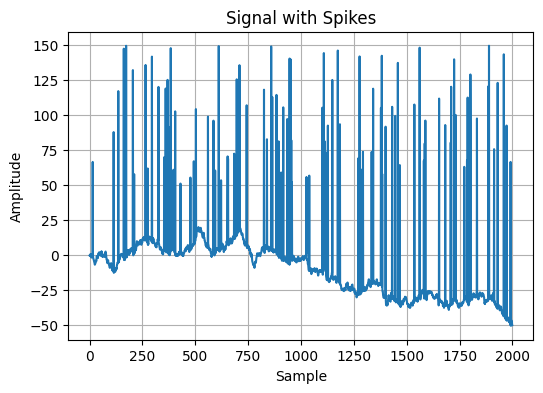

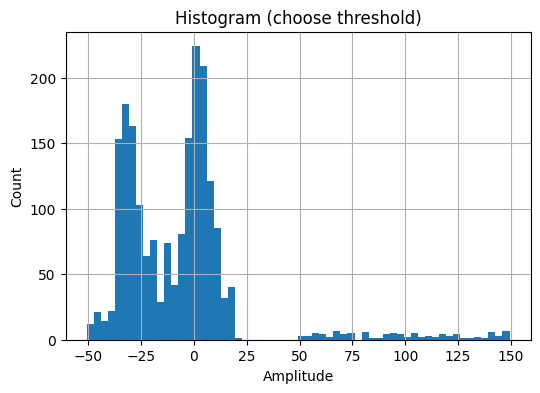

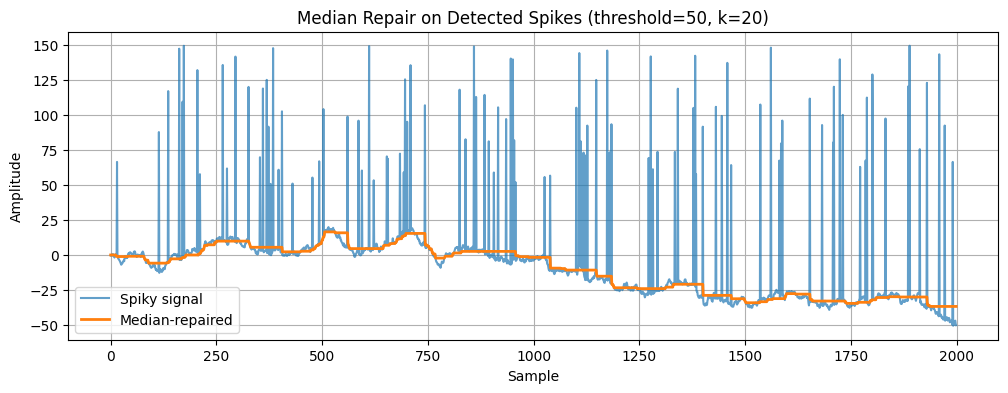

In [55]:

# 1) Create a random-walk signal
n = 2000
x = np.cumsum(np.random.randn(n))

# 2) Add spikes to a small percent of samples
prop_spikes = 0.05
num_spikes = int(n * prop_spikes)

spike_idx = np.random.permutation(n)[:num_spikes]
x[spike_idx] = 50 + np.random.rand(num_spikes) * 100  # big spikes

# 3) Plot the signal and its histogram (to choose threshold)
plt.figure(figsize=(6, 4))
plt.plot(x)
plt.title("Signal with Spikes")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(x, bins=60)
plt.title("Histogram (choose threshold)")
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 4) Detect spikes
threshold = 50
spike_locs = np.where(x > threshold)[0]


# 6) Plot before vs after
plt.figure(figsize=(12, 4))
plt.plot(x, label="Spiky signal", alpha=0.7)
# 5) Median-repair ONLY the spikes
k = 20  # half-window (total window = 2k+1)
y = x.copy()
y = Medianfilter(y, k)
plt.plot(y, label="Median-repaired", linewidth=2)
plt.title(f"Median Repair on Detected Spikes (threshold={threshold}, k={k})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()



## Transient Activity Enhancement with the Teager–Kaiser Energy Operator (TKEO)

TKEO is a simple, time-domain operator that emphasizes rapid energy changes in a signal.
It is useful for highlighting bursts of activity (common in EMG / vibration / sensors).

**Definition**
\[
\Psi[x_t] = x_t^2 - x_{t-1}x_{t+1}
\]

We compare:
1) EMG vs TKEO (normalized by max for visual comparison)
2) EMG Z-score vs TKEO Z-score using a baseline window (t < 0)


In [66]:
def teager_kaiser_energy(signal):
    """Compute the TKEO of the signal."""
    tkeo_signal = np.zeros_like(signal)
    for i in range(1, len(signal) - 1):
        tkeo_signal[i] = signal[i] ** 2 - signal[i - 1] * signal[i + 1]
    # Optionally set the endpoints to 0
    tkeo_signal[0] = 0
    tkeo_signal[-1] = 0
    return tkeo_signal

### Baseline Selection

We choose our baseline from the period before time zero because this is when the signal is in its normal, resting state (no muscle contraction). Our time array includes negative values, representing times before the event. By taking the absolute value of time and finding the smallest value, we identify the point closest to zero. All data before this time (the negative time portion) is used as our baseline.

This baseline helps us calculate Z-scores and detect deviations from the normal state, ensuring that we measure meaningful changes in the signal.


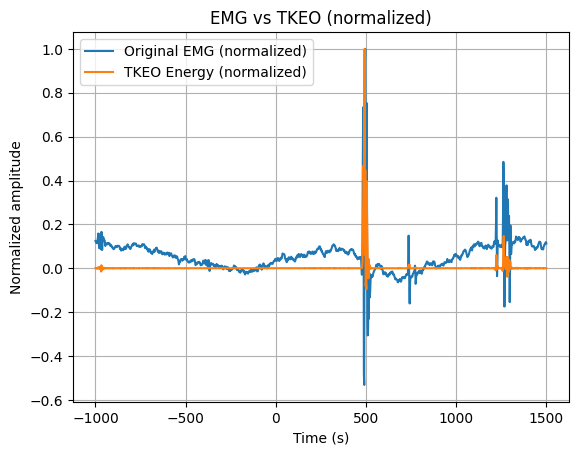

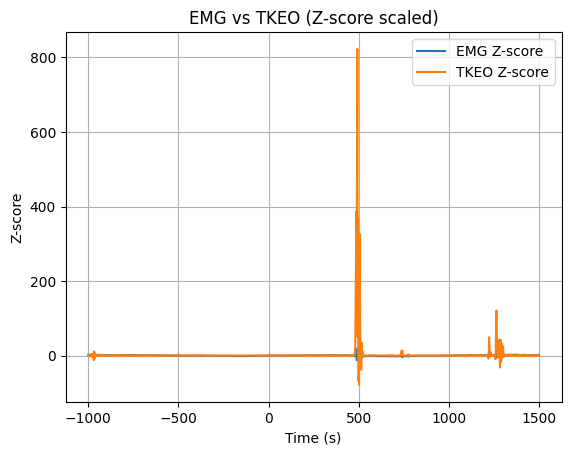

In [67]:
import scipy.io
import copy

# Load the data
emgdata = scipy.io.loadmat('/content/sample_data/EMG.mat')
emgtime = emgdata['emgtime'][0]
emg = emgdata['emg'][0]

# Apply the TKEO function
emgf = teager_kaiser_energy(emg)

# Convert both signals to Z-score using the baseline before time 0
time0 = np.argmin(np.abs(emgtime))
baseline_mean_emg = np.mean(emg[:time0])
baseline_std_emg = np.std(emg[:time0])

baseline_mean_emgf = np.mean(emgf[:time0])
baseline_std_emgf = np.std(emgf[:time0])

emgZ = (emg - baseline_mean_emg) / baseline_std_emg
emgZf = (emgf - baseline_mean_emgf) / baseline_std_emgf

# Plotting
plt.figure()
plt.plot(emgtime, emg / np.max(np.abs(emg)), label='Original EMG (normalized)')
plt.plot(emgtime, emgf / np.max(np.abs(emgf)), label='TKEO Energy (normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.title('EMG vs TKEO (normalized)')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(emgtime, emgZ, label='EMG Z-score')
plt.plot(emgtime, emgZf, label='TKEO Z-score')
plt.xlabel('Time (s)')
plt.ylabel('Z-score')
plt.title('EMG vs TKEO (Z-score scaled)')
plt.legend()
plt.grid(True)

plt.show()